In [192]:
import torch
from torch import nn
import transformers
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import umap

In [195]:
print(torch.__version__)
print(transformers.__version__)

2.0.0+cu118
4.28.0.dev0


In [224]:
import matplotlib as mpl
# default: 100
mpl.rcParams['figure.dpi'] = 300

## pipeline，认识 nlp tasks

In [5]:
from transformers import pipeline

- 文本分类：`pipeline("text-classification")`
    - sentiment analysis
- ner：`pipeline("ner", aggregation_strategy="simple")`
    - tagger
- qa: `pipeline("question-answering")`
    - reader
- Summarization: `pipeline("summarization")`
- Translation: 
    ```
    translator = pipeline("translation_en_to_de",
    model="Helsinki-NLP/opus-mt-en-de")
    ```
- Text Generation：`generator = pipeline("text-generation")`


## hugging face datasets

In [7]:
from datasets import list_datasets

In [8]:
all_datasets = list_datasets()

In [12]:
print(len(all_datasets))
print(all_datasets[:10])

28620
['acronym_identification', 'ade_corpus_v2', 'adversarial_qa', 'aeslc', 'afrikaans_ner_corpus', 'ag_news', 'ai2_arc', 'air_dialogue', 'ajgt_twitter_ar', 'allegro_reviews']


In [5]:
from datasets import load_dataset

In [6]:
emotions = load_dataset('emotion')

No config specified, defaulting to: emotion/split
Found cached dataset emotion (/home/whaow/.cache/huggingface/datasets/emotion/split/1.0.0/cca5efe2dfeb58c1d098e0f9eeb200e9927d889b5a03c67097275dfb5fe463bd)


  0%|          | 0/3 [00:00<?, ?it/s]

In [7]:
train_ds = emotions['train']

In [22]:
len(train_ds)

16000

In [23]:
train_ds[0]

{'text': 'i didnt feel humiliated', 'label': 0}

In [12]:
len(train_ds['text'])

16000

In [25]:
train_ds.features

{'text': Value(dtype='string', id=None),
 'label': ClassLabel(names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], id=None)}

In [26]:
train_ds[:5]

{'text': ['i didnt feel humiliated',
  'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake',
  'im grabbing a minute to post i feel greedy wrong',
  'i am ever feeling nostalgic about the fireplace i will know that it is still on the property',
  'i am feeling grouchy'],
 'label': [0, 0, 3, 2, 3]}

### datasets => dataframes

In [34]:
import pandas as pd

In [76]:
# emotions.reset_format()
emotions.set_format(type='pandas')

In [36]:
df = emotions['train'][:]

In [31]:
df.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


In [37]:
def label_int2str(row):
    return emotions["train"].features["label"].int2str(row)

In [38]:
df['label_name'] = df['label'].apply(label_int2str)

In [36]:
df.head(10)

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger
5,ive been feeling a little burdened lately wasn...,0,sadness
6,ive been taking or milligrams or times recomme...,5,surprise
7,i feel as confused about life as a teenager or...,4,fear
8,i have been with petronas for years i feel tha...,1,joy
9,i feel romantic too,2,love


In [38]:
# sadness => joy => love => anger => fear => surprise
df.label.value_counts()

1    5362
0    4666
3    2159
4    1937
2    1304
5     572
Name: label, dtype: int64

### 可视化分析

In [40]:
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'freq of classes')

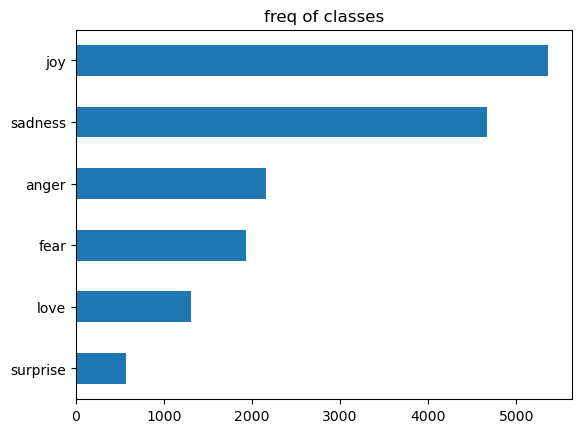

In [41]:
df['label_name'].value_counts(ascending=True).plot.barh()
plt.title('freq of classes')

Text(0.5, 0, '')

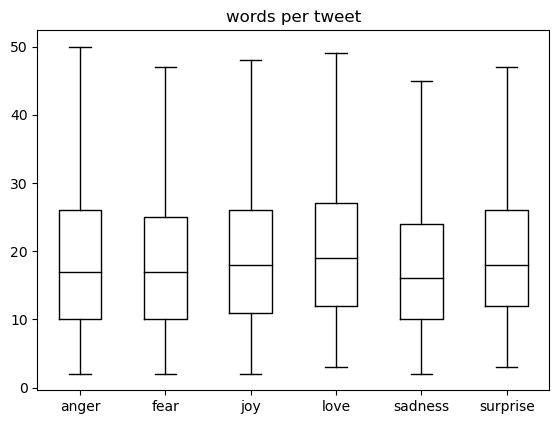

In [42]:
df['words per tweet'] = df['text'].str.split().apply(len)
df.boxplot('words per tweet', by='label_name', showfliers=False, grid=False, color='black')
plt.suptitle('')
plt.xlabel('')

In [45]:
print(df['words per tweet'].max())
print(df['words per tweet'].idxmax())

66
6322


## from text to tokens

- Subword Tokenization
    - WordPiece
        - BERT and DistilBERT
- hugging face:
    - `~/.cache/huggingface`

In [1]:
from transformers import AutoTokenizer

In [2]:
model_ckpt = 'distilbert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

# from transformers import DistilBertTokenizer
# distilbert_tokenizer = DistilBertTokenizer.from_pretrained(model_ckpt)

In [3]:
# uncased
print(tokenizer.encode('hello world'))
print(tokenizer.encode('Hello World'))
print(tokenizer.encode('HELLO WORLD'))

[101, 7592, 2088, 102]
[101, 7592, 2088, 102]
[101, 7592, 2088, 102]


In [4]:
sample = 'Tokenizing text is a core task of NLP.'

In [62]:
encoded_text = tokenizer(sample)

In [64]:
tokens = tokenizer.convert_ids_to_tokens(encoded_text['input_ids'])

In [65]:
tokenizer.convert_tokens_to_string(tokens)

'[CLS] tokenizing text is a core task of nlp. [SEP]'

### 属性及成员

- `tokenizer.vocab_size`
- model config
    - `tokenizer.model_max_length`
    - `tokenizer.model_input_names`

In [66]:
tokenizer.vocab_size

30522

In [67]:
tokenizer.model_max_length

512

In [22]:
tokenizer.special_tokens_map

{'unk_token': '[UNK]',
 'sep_token': '[SEP]',
 'pad_token': '[PAD]',
 'cls_token': '[CLS]',
 'mask_token': '[MASK]'}

In [25]:
for key, token in tokenizer.special_tokens_map.items():
    print(token, tokenizer.convert_tokens_to_ids([token]))

[UNK] [100]
[SEP] [102]
[PAD] [0]
[CLS] [101]
[MASK] [103]


### tokenizing the whole dataset

In [144]:
emotions.reset_format()

In [61]:
emotions['train']

Dataset({
    features: ['text', 'label'],
    num_rows: 16000
})

In [62]:
train_ds = emotions['train']

In [63]:
def batch_tokenize(batch):
    return tokenizer(batch['text'], padding=True, truncation=True)

In [64]:
train_ds[:10]

{'text': ['i didnt feel humiliated',
  'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake',
  'im grabbing a minute to post i feel greedy wrong',
  'i am ever feeling nostalgic about the fireplace i will know that it is still on the property',
  'i am feeling grouchy',
  'ive been feeling a little burdened lately wasnt sure why that was',
  'ive been taking or milligrams or times recommended amount and ive fallen asleep a lot faster but i also feel like so funny',
  'i feel as confused about life as a teenager or as jaded as a year old man',
  'i have been with petronas for years i feel that petronas has performed well and made a huge profit',
  'i feel romantic too'],
 'label': [0, 0, 3, 2, 3, 0, 5, 4, 1, 2]}

In [78]:
model_inputs = batch_tokenize(batch=train_ds[:10])

In [105]:
# 以 101(CLS) 开头, 102(SEP): 结束
# 不足补0（pad）
# model_inputs['input_ids'][0]

In [145]:
emotions_encoded = emotions.map(batch_tokenize, batched=True, batch_size=None)

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [116]:
list(map(len, emotions_encoded['train']['input_ids']))[:30]

[87,
 87,
 87,
 87,
 87,
 87,
 87,
 87,
 87,
 87,
 87,
 87,
 87,
 87,
 87,
 87,
 87,
 87,
 87,
 87,
 87,
 87,
 87,
 87,
 87,
 87,
 87,
 87,
 87,
 87]

## training a text classifier

In [80]:
from IPython.display import Image

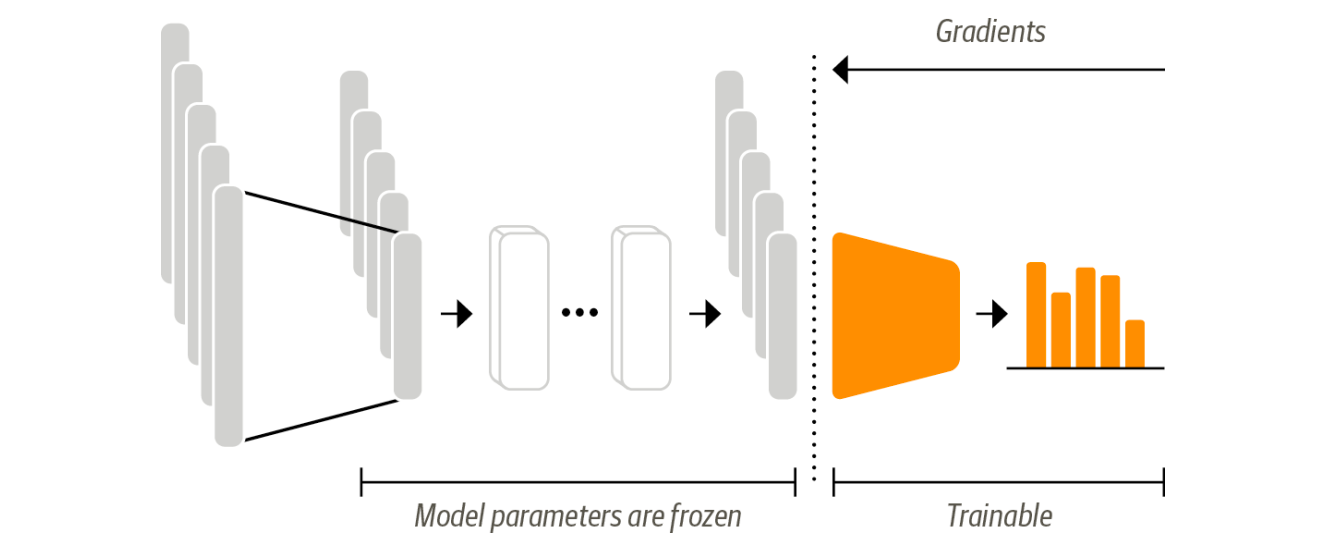

In [81]:
Image('../imgs/transformer_as_feature_extractor.png')

### feature extraction (transformers as feature extractors)

- **hidden states** as features
    - a hidden state for each input token
- train a classifier on them (the hidden states)
    - without modifying the pretrained model

In [86]:
import torch
from transformers import AutoModel, AutoTokenizer

In [87]:
model_ckpt = 'distilbert-base-uncased'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = AutoModel.from_pretrained(model_ckpt).to(device)
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [90]:
tokenizer.model_input_names

['input_ids', 'attention_mask']

#### model forward & hidden states

In [88]:
sample = 'this is a test sentence.'
model_inputs = tokenizer(sample, return_tensors='pt')

In [89]:
model_inputs

{'input_ids': tensor([[ 101, 2023, 2003, 1037, 3231, 6251, 1012,  102]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1]])}

In [129]:
def to_device(input_dict):
    return {k: v.to(device) for k, v in input_dict.items() if k in tokenizer.model_input_names}

In [130]:
model_inputs = to_device(model_inputs)

In [94]:
model_inputs

{'input_ids': tensor([[ 101, 2023, 2003, 1037, 3231, 6251, 1012,  102]], device='cuda:0'),
 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1]], device='cuda:0')}

In [95]:
# context manager to disable the automatic calculation of the gradient. 
# reduces the memory footprint of the computations.
with torch.no_grad():
    outputs = model(**model_inputs)

In [96]:
outputs

BaseModelOutput(last_hidden_state=tensor([[[-0.1900, -0.1667, -0.0323,  ..., -0.0682,  0.0702,  0.4371],
         [-0.4483, -0.5599, -0.2250,  ..., -0.1913,  0.3570,  0.4449],
         [-0.3673, -0.3406, -0.0231,  ..., -0.0682, -0.1296,  0.9672],
         ...,
         [ 0.3280, -0.0990, -0.1772,  ..., -0.1902, -0.0443, -0.2406],
         [ 0.7468, -0.0458, -0.5156,  ...,  0.3115, -0.6807, -0.3057],
         [ 0.1028, -0.1866,  0.1478,  ...,  0.1714, -0.7042,  0.2342]]],
       device='cuda:0'), hidden_states=None, attentions=None)

In [98]:
# batch_size, n_tokens, hidden_dim
outputs['last_hidden_state'].shape

torch.Size([1, 8, 768])

In [100]:
# for classification, it is common practice to just 
# use the hidden state associated with the [CLS] token as the input feature
outputs['last_hidden_state'][:, 0].shape
outputs['last_hidden_state'][:, 0, :].shape

torch.Size([1, 768])

In [149]:
def batch_extract_hidden_states(batch):
    batch_inputs = to_device(batch)
    with torch.no_grad():
        outputs = model(**batch_inputs)
    return {'hidden_state': outputs.last_hidden_state[:, 0, :].cpu().numpy()}

In [150]:
# to torch (tensor)
emotions_encoded.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])

In [151]:
emotions_encoded

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 2000
    })
})

In [153]:
emotions_hidden = emotions_encoded.map(batch_extract_hidden_states, batched=True)

Loading cached processed dataset at /home/whaow/.cache/huggingface/datasets/emotion/split/1.0.0/cca5efe2dfeb58c1d098e0f9eeb200e9927d889b5a03c67097275dfb5fe463bd/cache-6c71ba9943ab2023.arrow
Loading cached processed dataset at /home/whaow/.cache/huggingface/datasets/emotion/split/1.0.0/cca5efe2dfeb58c1d098e0f9eeb200e9927d889b5a03c67097275dfb5fe463bd/cache-f41d2ed017f3d41e.arrow
Loading cached processed dataset at /home/whaow/.cache/huggingface/datasets/emotion/split/1.0.0/cca5efe2dfeb58c1d098e0f9eeb200e9927d889b5a03c67097275dfb5fe463bd/cache-b7155d4d79c40b1f.arrow


In [173]:
X_train = emotions_hidden['train']['hidden_state'].numpy()
y_train = emotions_hidden['train']['label'].numpy()
print(X_train.shape, y_train.shape)
X_valid = emotions_hidden['validation']['hidden_state'].numpy()
y_valid = emotions_hidden['validation']['label'].numpy()
print(X_valid.shape, y_valid.shape)

(16000, 768) (16000,)
(2000, 768) (2000,)


#### use the hidden state

In [191]:
# !pip install umap-learn

In [196]:
import umap.umap_ as umap
from sklearn.preprocessing import MinMaxScaler

In [200]:
X_scaled = MinMaxScaler().fit_transform(X_train)
# from 768 => 2
mapper = umap.UMAP(n_components=2, metric='cosine').fit(X_scaled)

In [207]:
df_emb = pd.DataFrame(mapper.embedding_, columns=['X', 'Y'])
df_emb['label'] = y_train

In [208]:
df_emb.head()

,X,Y,label
0,4.427019,6.065405,0
1,-2.860053,5.560841,0
2,5.393857,2.509877,3
3,-1.983451,3.276028,2
4,-3.219790,3.246893,3


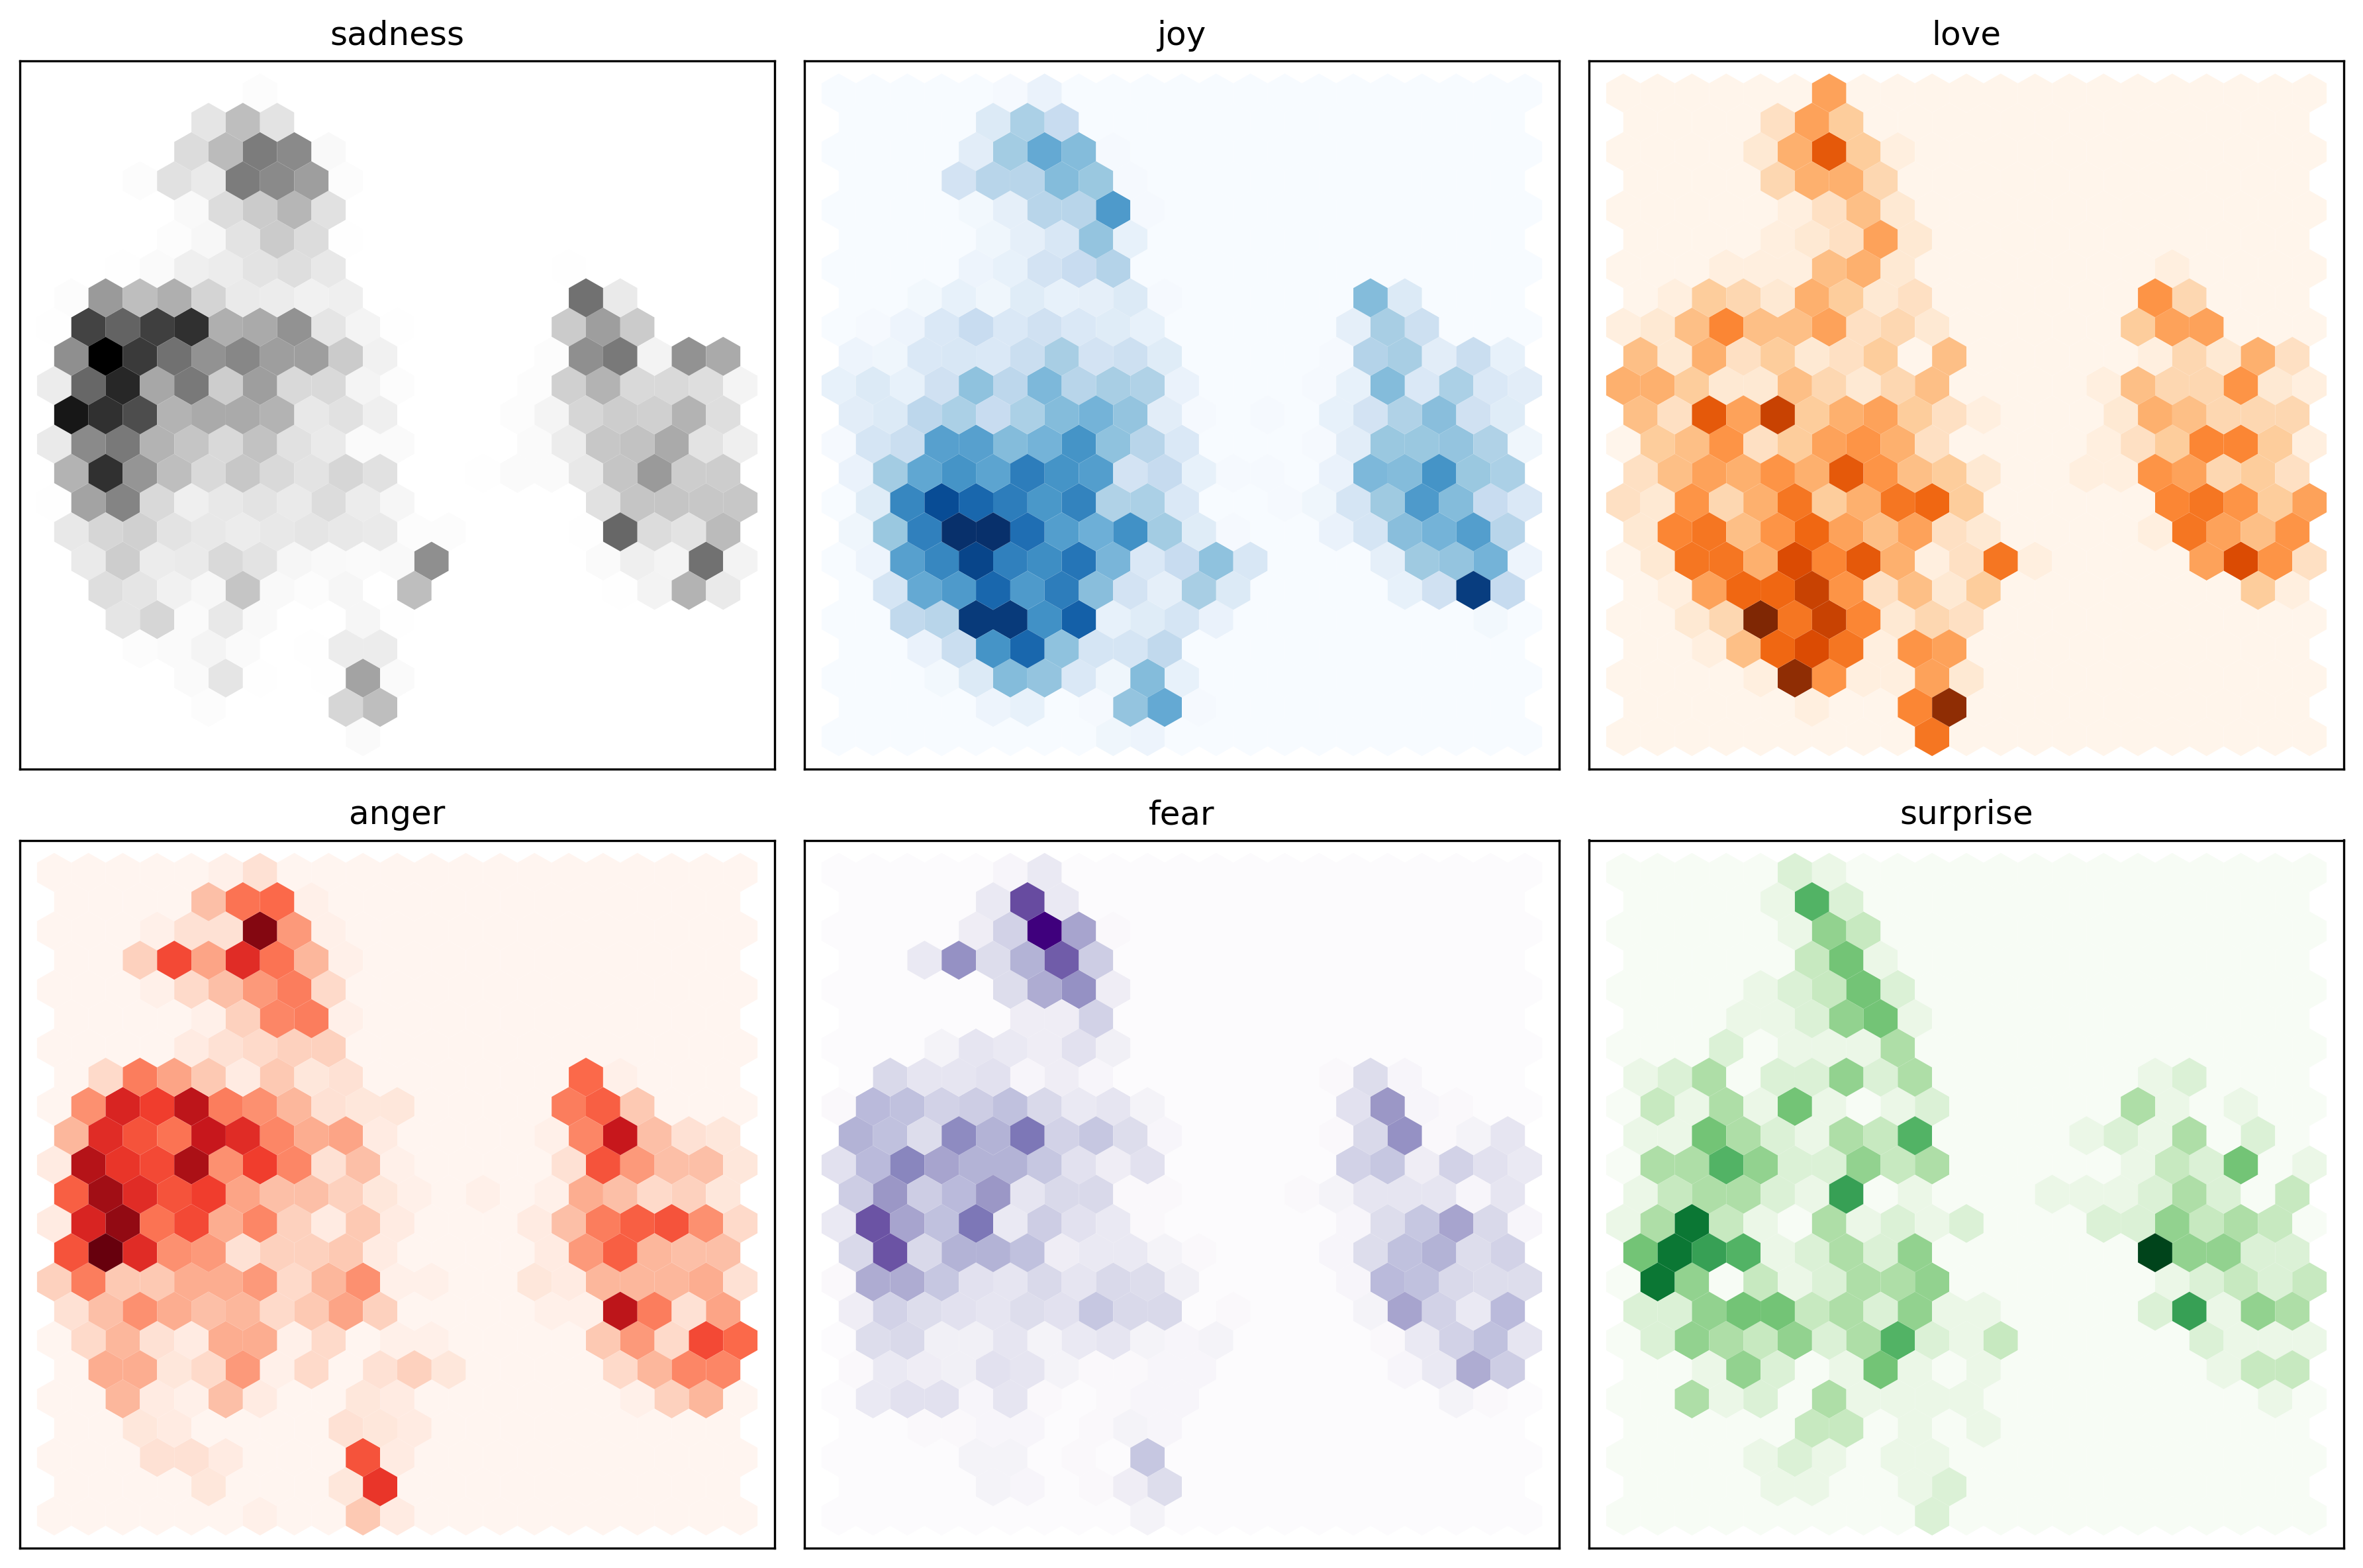

In [225]:
fig, axes = plt.subplots(2, 3, figsize=(12,8))
axes = axes.flatten()
cmaps = ["Greys", "Blues", "Oranges", "Reds", "Purples", "Greens"]
labels = emotions["train"].features["label"].names
for i, (label, cmap) in enumerate(zip(labels, cmaps)):
    df_emb_sub = df_emb.query(f"label == {i}")
    axes[i].hexbin(df_emb_sub["X"], df_emb_sub["Y"], cmap=cmap, gridsize=20, linewidths=(0,))
    axes[i].set_title(label)
    axes[i].set_xticks([]), axes[i].set_yticks([])
plt.tight_layout()

#### classic machine learning classifier

In [229]:
from sklearn.dummy import DummyClassifier
dummy_clf = DummyClassifier(strategy='most_frequent')
dummy_clf.fit(X_train, y_train)
dummy_clf.score(X_valid, y_valid)

0.352

In [234]:
print(dummy_clf.class_prior_)
np.mean(y_valid == 1)

[0.291625  0.335125  0.0815    0.1349375 0.1210625 0.03575  ]


0.352

In [228]:
from sklearn.linear_model import LogisticRegression
lr_clf = LogisticRegression(max_iter=3000)
lr_clf.fit(X_train, y_train)
lr_clf.score(X_valid, y_valid)

0.633

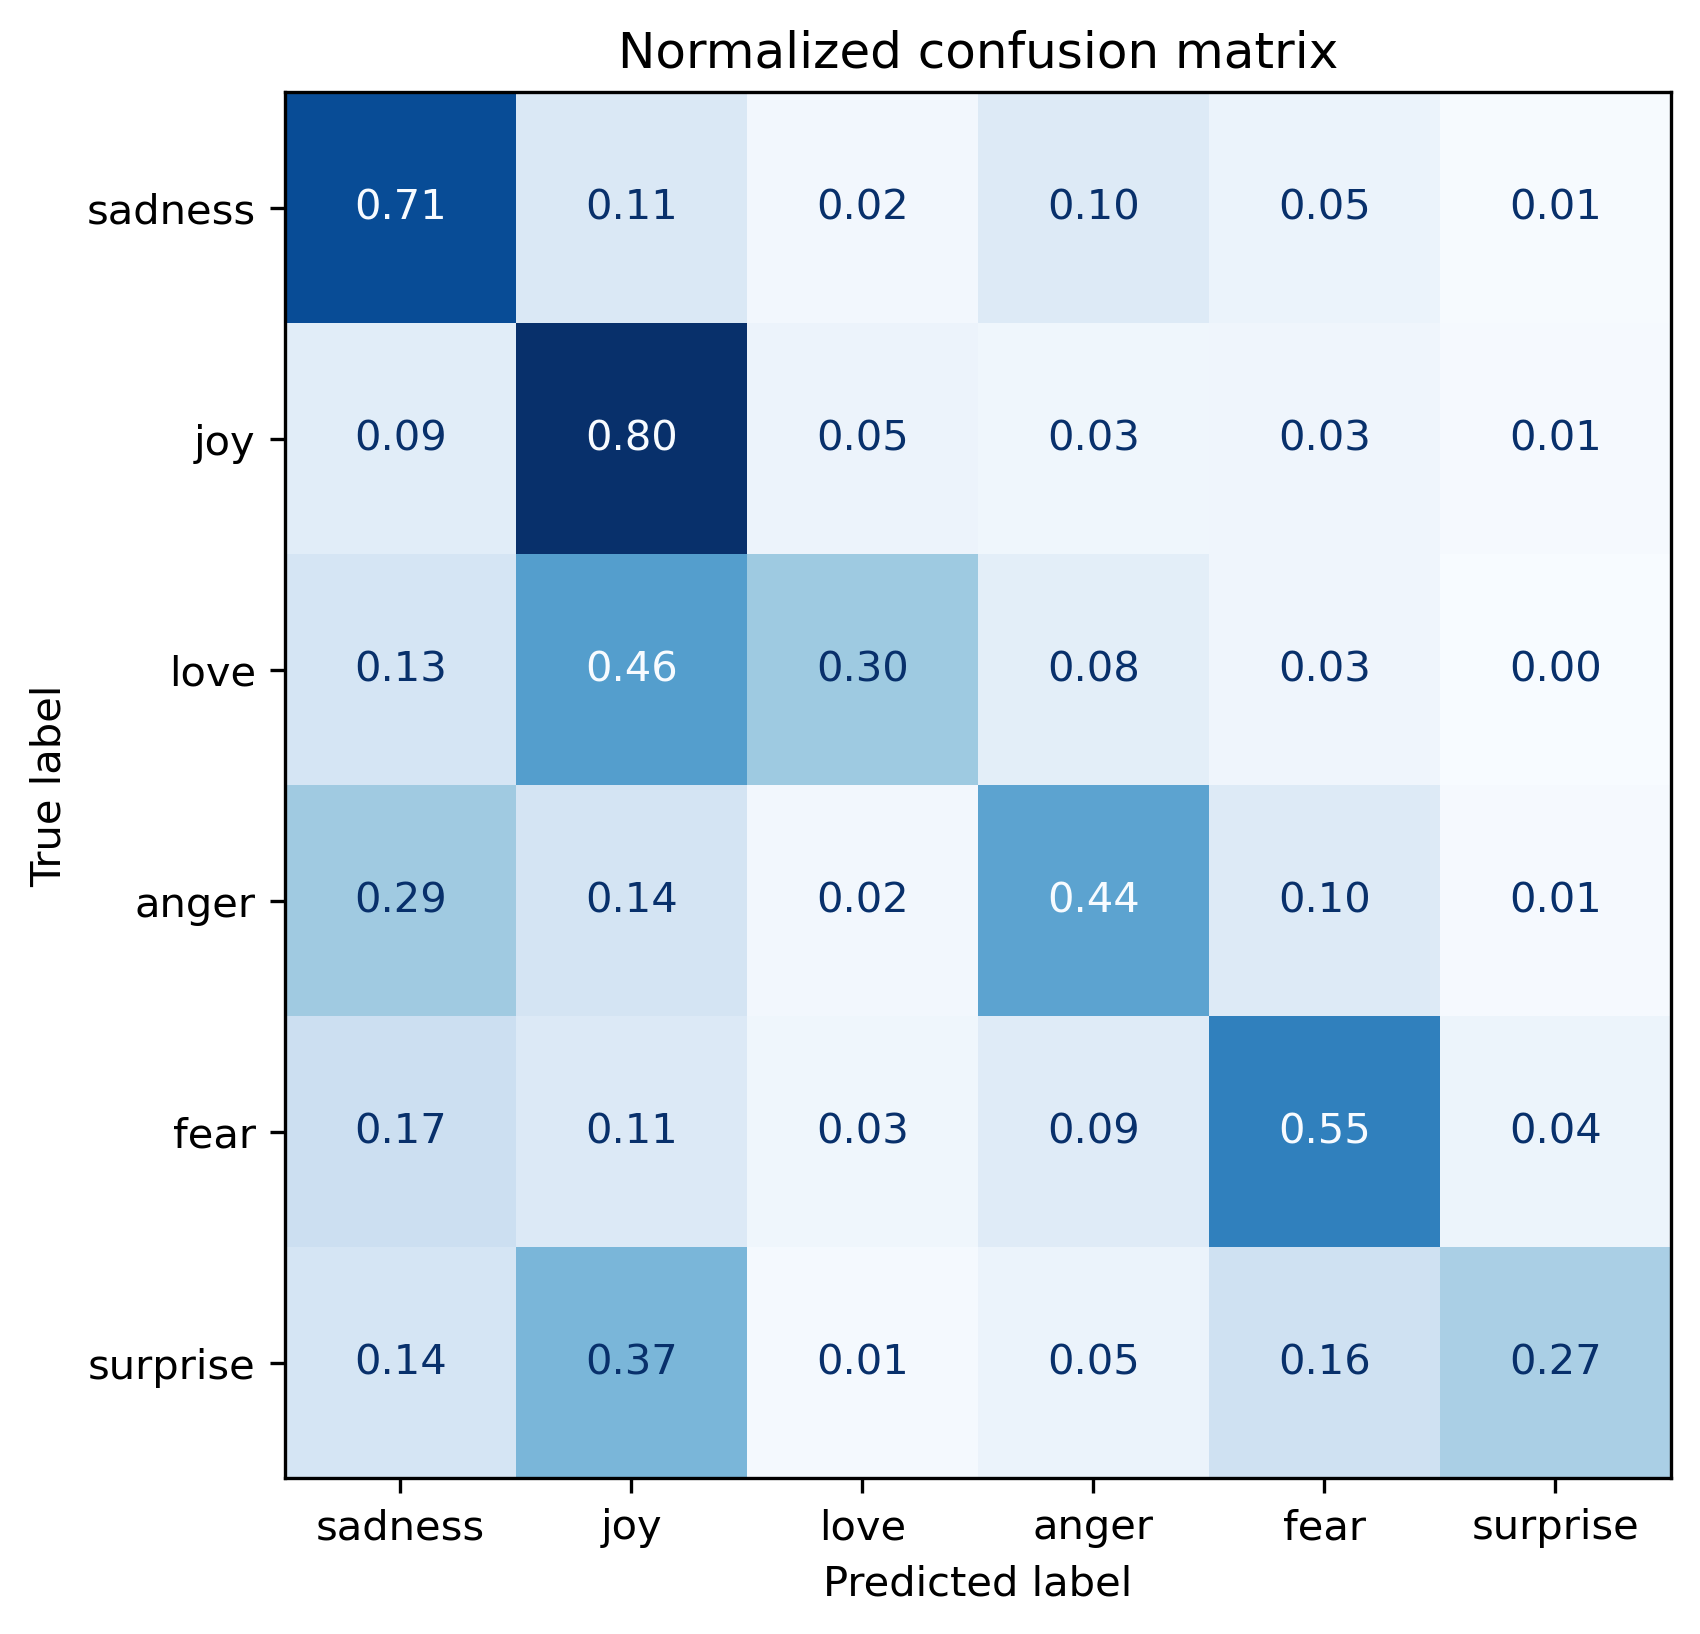

In [235]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()
y_preds = lr_clf.predict(X_valid)
plot_confusion_matrix(y_preds, y_valid, labels)

### fine-tune transformers

In [237]:
from transformers import AutoModel
model_ckpt = 'distilbert-base-uncased'
model = AutoModel.from_pretrained(model_ckpt)
model

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


DistilBertModel(
  (embeddings): Embeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): Transformer(
    (layer): ModuleList(
      (0-5): 6 x TransformerBlock(
        (attention): MultiHeadSelfAttention(
          (dropout): Dropout(p=0.1, inplace=False)
          (q_lin): Linear(in_features=768, out_features=768, bias=True)
          (k_lin): Linear(in_features=768, out_features=768, bias=True)
          (v_lin): Linear(in_features=768, out_features=768, bias=True)
          (out_lin): Linear(in_features=768, out_features=768, bias=True)
        )
        (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (ffn): FFN(
          (dropout): Dropout(p=0.1, inplace=False)
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Li

In [242]:
from transformers import AutoModelForSequenceClassification
model_ckpt = 'distilbert-base-uncased'
model = AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=6).to(device)
model

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'pre_classifier.weight', 'pre_clas

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

In [244]:
from sklearn.metrics import accuracy_score, f1_score
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

In [254]:
from huggingface_hub import notebook_login
notebook_login()

Token is valid.
Your token has been saved in your configured git credential helpers (store).
Your token has been saved to /home/whaow/.cache/huggingface/token
Login successful


In [258]:
from transformers import Trainer, TrainingArguments
batch_size = 64
logging_steps = len(emotions_encoded["train"]) // batch_size
model_name = f"{model_ckpt}-finetuned-emotion"
training_args = TrainingArguments(output_dir=model_name,
            num_train_epochs=2,
            learning_rate=2e-5,
            per_device_train_batch_size=batch_size,
            per_device_eval_batch_size=batch_size,
            weight_decay=0.01,
            evaluation_strategy="epoch",
            disable_tqdm=False,
            logging_steps=logging_steps,
            push_to_hub=True,
            log_level="error")

In [259]:
from transformers import Trainer
trainer = Trainer(model=model, args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=emotions_encoded["train"],
    eval_dataset=emotions_encoded["validation"],
    tokenizer=tokenizer)
trainer.train()

/home/whaow/workspaces/bert_t5_gpt/tutorials/distilbert-base-uncased-finetuned-emotion is already a clone of https://huggingface.co/lanchunhui/distilbert-base-uncased-finetuned-emotion. Make sure you pull the latest changes with `repo.git_pull()`.
/home/whaow/anaconda3/lib/python3.10/site-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/home/whaow/anaconda3/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.193238,0.927500,0.927184
2,0.207300,0.176952,0.931500,0.931686


/home/whaow/anaconda3/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


TrainOutput(global_step=250, training_loss=0.20726832580566407, metrics={'train_runtime': 28.6285, 'train_samples_per_second': 1117.766, 'train_steps_per_second': 8.733, 'total_flos': 720342861696000.0, 'train_loss': 0.20726832580566407, 'epoch': 2.0})

In [260]:
preds_output = trainer.predict(emotions_encoded["validation"])

/home/whaow/anaconda3/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


In [261]:
preds_output.metrics

{'test_loss': 0.1769522726535797,
 'test_accuracy': 0.9315,
 'test_f1': 0.931685654172238,
 'test_runtime': 0.6413,
 'test_samples_per_second': 3118.759,
 'test_steps_per_second': 24.95}

In [262]:
y_preds = np.argmax(preds_output.predictions, axis=1)

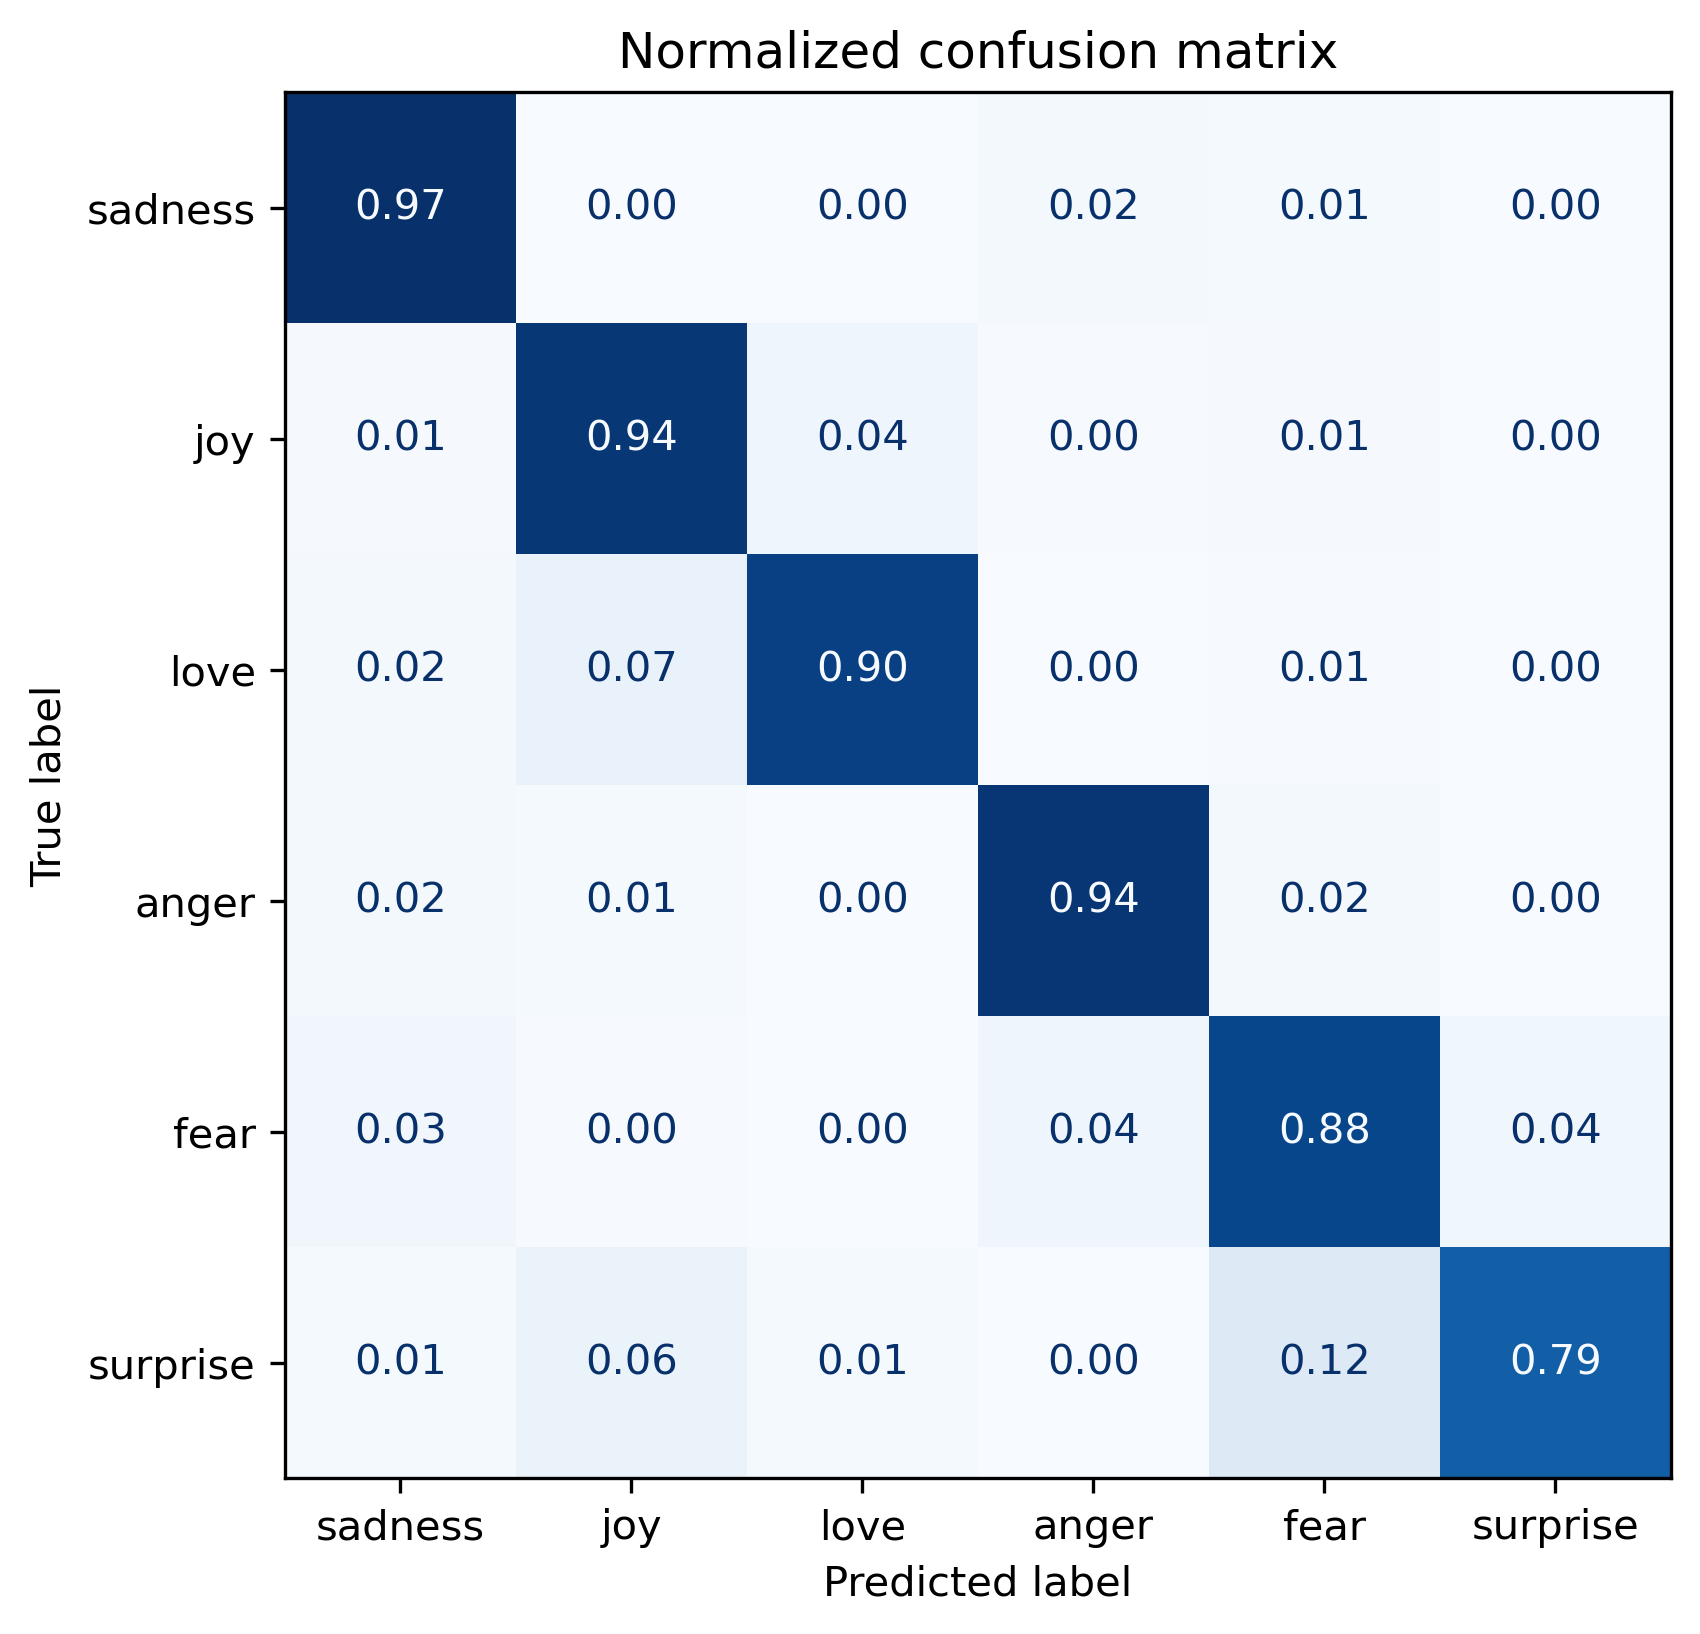

In [263]:
plot_confusion_matrix(y_preds, y_valid, labels)

## error analysis